# importing packages

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import trange 
import torch.nn.functional as F
import pickle
from torch.nn import Parameter
import torch
import math

# creating the graphe and layout

In [66]:
dfEdges=pd.read_csv(r'./data/edges.csv')

In [67]:
dfEdges.head()

,id_1,id_2
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [68]:
dfTargets=pd.read_csv(r"./data/targets.csv")

In [69]:
dfTargets.head()

,id_,label
0,31336,1
1,1061127,2
2,1106406,3
3,13195,3
4,37879,4


In [70]:
G=nx.convert_matrix.from_pandas_edgelist(dfEdges,"id_1","id_2")

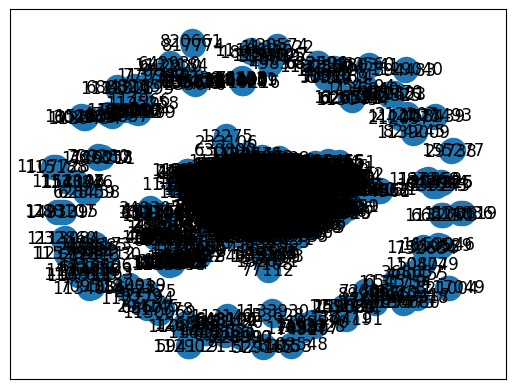

In [71]:
ax = plt.gca()
pos=nx.spring_layout(G,seed=42)
nx.draw_networkx(G,pos,nodelist=pos)

# color attributes 

In [72]:
l=[]
for node in G.nodes:
    l.append(dfTargets [dfTargets['id_'] == node]['label'])

# plotting the graph

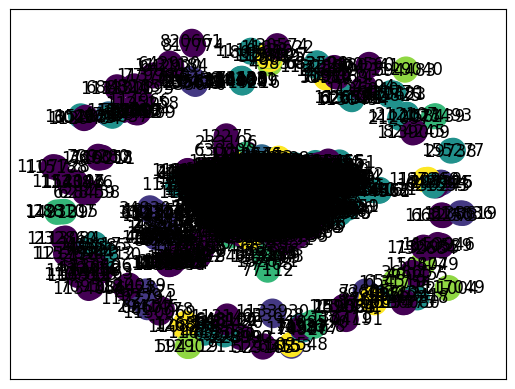

In [73]:
ax = plt.gca()
pos=nx.spring_layout(G,seed=42)
nx.draw_networkx(G,pos,nodelist=pos ,node_color=l)

# data preprocessing


In [74]:
with open('data.pkl', 'rb') as f:
  data = pickle.load(f)

In [75]:
adj = data["adj"]
features = data["features"]
labels = data["labels"]
idx_train = data["idx_train"]
idx_val = data["idx_val"]
idx_test = data["idx_test"]

In [76]:
for k,v in data.items():
    print(f'{k} : ',v.shape)

adj :  torch.Size([2708, 2708])
features :  torch.Size([2708, 1433])
labels :  torch.Size([2708])
idx_train :  torch.Size([140])
idx_val :  torch.Size([300])
idx_test :  torch.Size([1000])


# MLP

## utilities

In [77]:
def num_params(model):
    """returns model parameters

    Args:
        model : torch model

    Returns:
        int : number of parameters
    """
    n = sum(p.numel() for p in model.parameters() if p.requires_grad) 
    return n

def get_predictions(output, labels):
    """returns number of correct predictions

    Args:
        output : predected labels
        labels : true labels

    Returns:
        int : 
    """
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    return correct


def accuracy(output, labels):
    """calculates model accuracy 

    Args:
        output : predicted labels
        labels : true labels

    Returns:
        int : model accuracy
    """
    correct = get_predictions(output, labels)
    correct = correct.sum()
    return correct/len(labels)

def mlp_accuracy(model,input,labels):
    """
    Perfom a forward pass `y_pred = model(x)` and computes the accuracy
    between `y_pred` and `y_true`
    """
    model.eval()
    y_pred = model(input)
    acc = accuracy(y_pred,labels)
    print(f"Accuracy: {acc:.5}")
    return acc

# MPL accuracy

In [78]:
# model creation
mlp = nn.Sequential(nn.Linear(1433,500),
                    nn.ReLU(),
                    nn.Linear(500,100),
                    nn.ReLU(),
                    nn.Linear(100,7),
                    nn.Softmax())

# accuracy before training

In [79]:
print("Loss before training")
mlp_accuracy(mlp,features[idx_test],labels[idx_test])

Loss before training
Accuracy: 0.159


c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.1590, dtype=torch.float64)

# training the MPL 

In [80]:
opt = optim.Adam(mlp.parameters())
losses = []
mlp.train()

for epoch in trange(500):
    opt.zero_grad()
    output = mlp(features[idx_train])
    loss = F.cross_entropy(output,labels[idx_train])
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
acc = mlp_accuracy(mlp,features[idx_test],labels[idx_test])
print("Loss after training ",acc )

100%|██████████| 500/500 [00:04<00:00, 104.30it/s]

Accuracy: 0.45
Loss after training  tensor(0.4500, dtype=torch.float64)


# model parameters

In [81]:
print('Number of parameters MLP: ', num_params(mlp))

Number of parameters MLP:  767807


# GraphConvolution

In [82]:
class GraphConvolution(nn.Module):
  """GraphConvolution

  Args:
      nn (nn.Module): heritage
  """
  def __init__(self, in_features, out_features):
    super(GraphConvolution, self).__init__()

    self.weight = Parameter(torch.FloatTensor(in_features,out_features))
    self.bias = Parameter(torch.FloatTensor(out_features))
    self.reset_parameters()

  def reset_parameters(self):
    stdv=1/math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv,stdv)
    self.bias.data.uniform_(-stdv,stdv)  

  def forward(self, input, adj):
    support = torch.mm(input,self.weight)
    output = torch.spmm(adj,support)
    return output+self.bias

In [83]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(nfeat,nhid)
        self.gcn2 = GraphConvolution(nhid,nclass)
    def forward(self, x, adj):
        x = F.relu(self.gcn1(x,adj))
        x = F.relu(self.gcn2(x,adj))
        return x

## model evaluation

In [84]:
def gcn_accuracy(model,features,adj):
    """model accuracy

    Args:
        model : _description_
        features : _description_
        adj : _description_

    Returns:
        int : model accuracy
    """
    model.eval()
    y_pred =  model(features,adj)
    acc =  accuracy(y_pred[idx_test],labels[idx_test])
    return acc 

# using the GCN

In [85]:
gcn = GCN(1433,50,7)

In [86]:
# before training
acc = gcn_accuracy(gcn,features,adj)
print(f"Loss before training {acc:.4f}")

Loss before training 0.1380


In [87]:
# training the GCN
opt = optim.Adam(gcn.parameters())

losses = []
gcn.train()
for epoch in trange(500):
    opt.zero_grad()
    output = gcn(features,adj)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 500/500 [00:05<00:00, 86.80it/s] 


In [88]:
# accuracy after training
acc = gcn_accuracy(gcn,features,adj)
print(f"Loss after training {acc:.4f} ")

Loss after training 0.4130 


In [89]:
# GCN parameters
params = num_params(gcn)
print(f'Number of parameters GCN: {params} ')

Number of parameters GCN: 72057 
